## 内容介绍

1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 评价函数与目标函数；
    - 交叉验证方法；
    - 留一验证方法；
    - 针对时间序列问题的验证；
    - 绘制学习率曲线；
    - 绘制验证曲线；
3. 嵌入式特征选择：
    - Lasso回归；
    - Ridge回归；
    - 决策树；
4. 模型对比：
    - 常用线性模型；
    - 常用非线性模型；
5. 模型调参：
    - 贪心调参方法；
    - 网格调参方法；
    - 贝叶斯调参方法；

In [48]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [49]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [50]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 88412768.00 MB
Memory usage after optimization is: 27444989.00 MB
Decreased by 69.0%


In [51]:
sample_feature

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,model_price_std,model_price_average,gearbox_amount,gearbox_price_max,gearbox_price_median,gearbox_price_min,gearbox_price_sum,gearbox_price_std,gearbox_price_average,power_bin
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,2230.0,2320.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,5.0
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,5524.0,6452.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,NaN
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,4696.0,9520.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,16.0
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,9848.0,10768.0,28314.0,92900.0,6500.0,15.0,256438016.0,8344.0,9056.0,19.0
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1366.0,1466.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184188,199995,20903,19960503,4.0,4,4.0,0.0,0.0,116,15.0,...,5784.0,6016.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,11.0
184189,199996,708,19991011,0.0,0,0.0,0.0,0.0,75,15.0,...,4532.0,4440.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,7.0
184190,199997,6693,20040412,49.0,1,0.0,1.0,1.0,224,15.0,...,7468.0,8360.0,28314.0,92900.0,6500.0,15.0,256438016.0,8344.0,9056.0,22.0
184191,199998,96900,20020008,27.0,1,0.0,0.0,1.0,334,15.0,...,9784.0,10072.0,28314.0,92900.0,6500.0,15.0,256438016.0,8344.0,9056.0,NaN


In [52]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model']]

* 十折交叉验证

In [53]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True) # 删除test集的数据
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32) # 将变量转为数值变量
train = sample_feature[continuous_feature_names + ['price']] # 训练数据集选用

train_X = train[continuous_feature_names]
train_y = train['price']

In [54]:
sample_feature

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,model_price_std,model_price_average,gearbox_amount,gearbox_price_max,gearbox_price_median,gearbox_price_min,gearbox_price_sum,gearbox_price_std,gearbox_price_average,power_bin
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,2230.0,2320.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,5.0
1,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,4696.0,9520.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,16.0
2,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1366.0,1466.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,6.0
3,5,137642,20090602,24.0,10,0.0,1.0,0.0,109,10.0,...,4054.0,9280.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,10.0
4,6,2402,19990411,13.0,4,0.0,0.0,1.0,150,15.0,...,7096.0,8084.0,28314.0,92900.0,6500.0,15.0,256438016.0,8344.0,9056.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84550,149992,183499,20001206,32.0,8,1.0,0.0,0.0,82,15.0,...,1394.0,1652.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,8.0
84551,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,4488.0,6596.0,28314.0,92900.0,6500.0,15.0,256438016.0,8344.0,9056.0,16.0
84552,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,4600.0,6776.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,12.0
84553,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,2886.0,3490.0,102160.0,99999.0,2550.0,13.0,430853120.0,4760.0,4216.0,8.0


* 线性模型

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('gearbox_price_min', 471555164369118.1),
 ('gearbox_price_std', 79673512759.705),
 ('gearbox_price_average', 76506825511.88092),
 ('v_6', 2498224.4408731856),
 ('v_8', 546400.3311923846),
 ('v_2', 55748.0029091761),
 ('v_9', 47534.01281191331),
 ('v_5', 30461.48770712906),
 ('v_7', 17104.059692410498),
 ('v_13', 15032.782079913697),
 ('fuelType', 228.36665691222132),
 ('power_bin', 219.58820191275984),
 ('v_0', 203.76670873857037),
 ('bodyType', 134.09040496226152),
 ('regionCode_amount', 9.76388838877244),
 ('city', 1.5574995322227947),
 ('model_price_average', 0.5077674968391566),
 ('model_price_std', 0.32400551178580256),
 ('regionCode_price_std', 0.29912780993505683),
 ('model_amount', 0.23862794088996248),
 ('used_time', 0.15448538957314037),
 ('brand_price_std', 0.15205014581813087),
 ('brand_price_average', 0.1471007895950908),
 ('regionCode_price_min', 0.1382661791967277),
 ('model_price_min', 0.11823430021625991),
 ('brand_price_median', 0.06937273889075848),
 ('creatDate', 

In [57]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

In [58]:
len(continuous_feature_names)

57

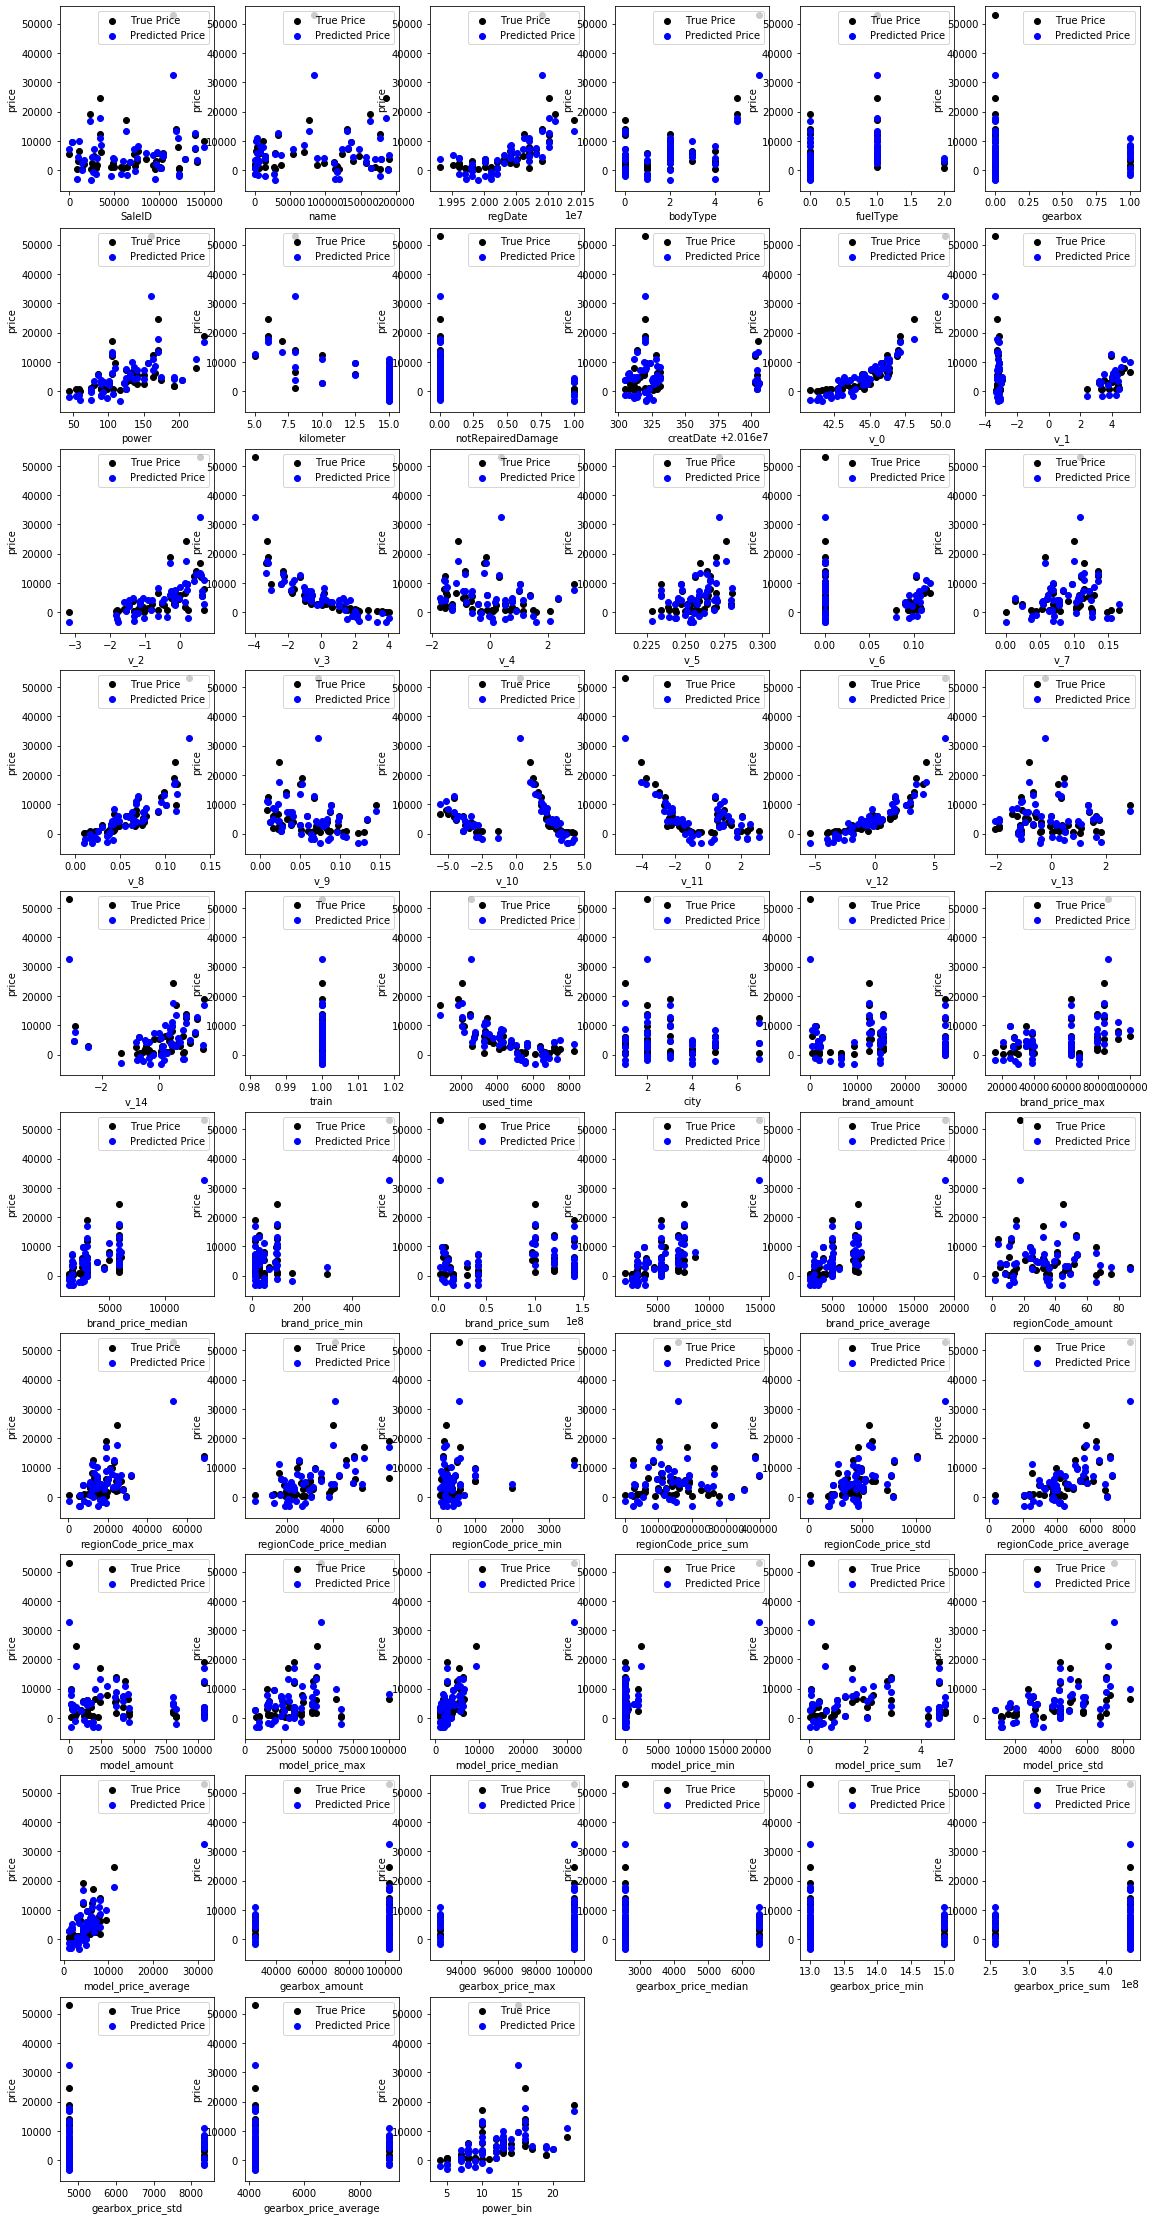

In [39]:
fig = plt.figure(figsize=(20, 40))
plt.subplots_adjust(left=0.15)
for i, c in enumerate(continuous_feature_names):
    ax = fig.add_subplot(10, 6, i + 1)
    plt.style.use('seaborn-dark-palette')
    plt.scatter(train_X[c][subsample_index], train_y[subsample_index], color='black')
    plt.scatter(train_X[c][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
    plt.xlabel(c)
    plt.ylabel('price')
    plt.legend(['True Price','Predicted Price'],loc='upper right')

plt.show()

It is clear to see the price shows a typical exponential distribution


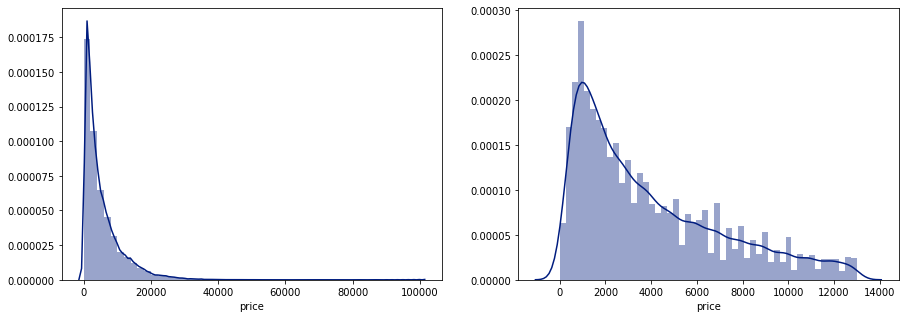

In [40]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [24]:
# train_y_ln = np.log(train_y + 1)

import scipy.stats as stats
train_y_ln = stats.boxcox(train_y)[0]

The transformed price seems like normal distribution


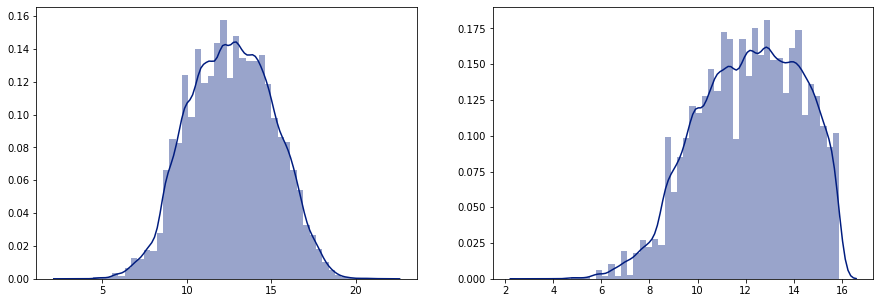

In [25]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [26]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:1802570520080.333


[('gearbox_price_min', 107335857327.82661),
 ('gearbox_price_average', 18725585.930744443),
 ('gearbox_price_std', 15277876.439539377),
 ('v_5', 26.729501710829954),
 ('v_9', 20.698290618039177),
 ('v_7', 5.505806451666418),
 ('v_13', 2.9136955835561604),
 ('v_3', 1.5242292991633475),
 ('v_12', 1.520023747110292),
 ('v_11', 1.270158585997341),
 ('fuelType', 0.025650848322904186),
 ('bodyType', 0.01681243061317121),
 ('power_bin', 0.011256190590349853),
 ('power', 0.003113678169812379),
 ('regionCode_amount', 0.0030639564485285013),
 ('regionCode_price_average', 5.0240742352993564e-05),
 ('model_price_std', 4.3594859796973564e-05),
 ('creatDate', 3.605897098861076e-05),
 ('brand_price_median', 2.354485291952809e-05),
 ('model_price_average', 2.2534379518078522e-05),
 ('regionCode_price_min', 2.1845634623150683e-05),
 ('brand_price_average', 1.8629810568263413e-05),
 ('model_amount', 1.643977808425882e-05),
 ('brand_amount', 6.7240200315649945e-06),
 ('regionCode_price_max', 1.9102020410

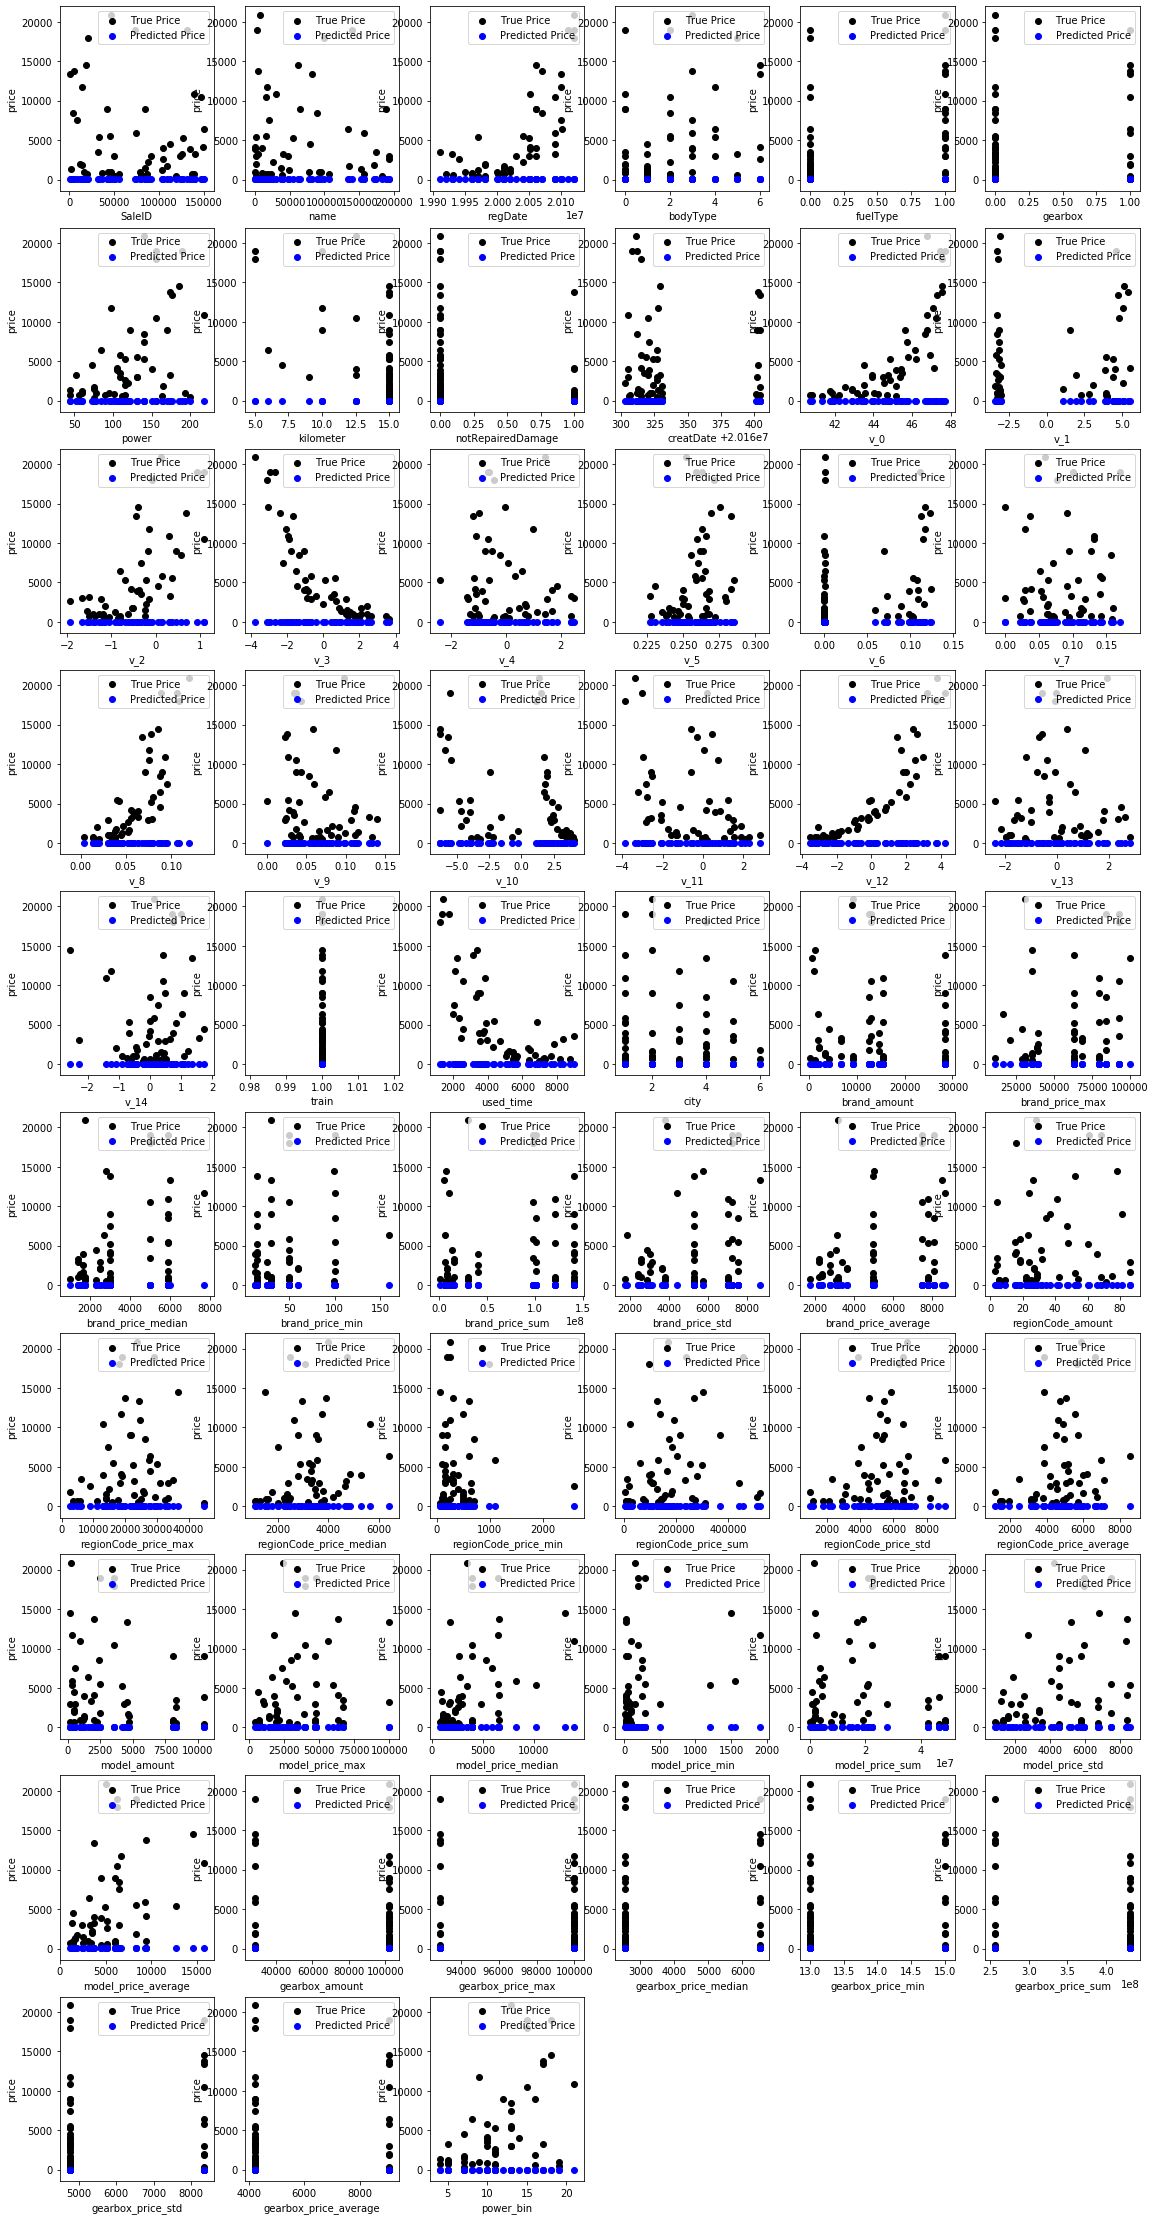

In [27]:
fig = plt.figure(figsize=(20, 40))
plt.subplots_adjust(left=0.15)
for i, c in enumerate(continuous_feature_names):
    ax = fig.add_subplot(10, 6, i + 1)
    plt.style.use('seaborn-dark-palette')
    plt.scatter(train_X[c][subsample_index], train_y[subsample_index], color='black')
    plt.scatter(train_X[c][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
    plt.xlabel(c)
    plt.ylabel('price')
    plt.legend(['True Price','Predicted Price'],loc='upper right')

plt.show()

* 五折交叉验证

> 在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

> 因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [60]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [61]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [62]:
print('AVG:', np.mean(scores))

AVG: inf


In [47]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [ ]:
print('AVG:', np.mean(scores))

In [ ]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

* 采用时间顺序对数据集进行划分

In [ ]:
import datetime

In [ ]:
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [ ]:
model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

* 绘制学习曲线和验证曲线

In [ ]:
from sklearn.model_selection import learning_curve, validation_curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

In [ ]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [ ]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)